Se instancian las librerías y herramientas necesarias para la ejecución de las tareas.

In [1]:
from sunpy.net import Fido, attrs as a

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sunpy.timeseries import TimeSeries
from __future__ import print_function, division

import datetime

import numpy as np
import pandas as pd
from glob import glob
import cv2 as cv

import astropy.units as u
from astropy.time import Time
from astropy.table import Table

import sunpy.data.sample
import sunpy.map
from sunpy.util.metadata import MetaDict
from sunpy.time import TimeRange, parse_time

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import peak_local_max
from astropy.io import fits

Se muestra información general del script y se le solicita al usuario que ingrese un rango de tiempo con el que se buscará en la base de datos el TimeSeries del XRS (sensor de rayos X).

In [2]:
#Se imprime en terminal información general del script
print("El presente script busca y descarga los TimeSeries de las curvas XRS,\na partir de un rango de tiempo que ingresa el usuario.")
print("Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.")
print("Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las\nintensidades de las imágenes FITS en una región de interés (ROI).")
print("-------------------------------------------------------------------------------------------")
print("Ingrese las fechas en cualquiera de los siguientes formatos:\n- 2007-May-04 21:08:12\n- 2007-05-04T21:08:12\n- 2007/05/04T21:08:12")
print("- 20070504T210812\n- 20070504_210812\n")
initialTime = raw_input("Ingrese fecha inicial: ")
finalTime = raw_input("Ingrese fecha final: ")

#2011-06-07 05:30

#Se crea TimeRange con las fechas ingresadas y se imprime
time_range = TimeRange(initialTime, finalTime)
print("\nEl intervalo de tiempo ingresado es:\n", time_range)

El presente script busca y descarga los TimeSeries de las curvas XRS,
a partir de un rango de tiempo que ingresa el usuario.
Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.
Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las
intensidades de las imágenes FITS en una región de interés (ROI).
-------------------------------------------------------------------------------------------
Ingrese las fechas en cualquiera de los siguientes formatos:
- 2007-May-04 21:08:12
- 2007-05-04T21:08:12
- 2007/05/04T21:08:12
- 20070504T210812
- 20070504_210812

Ingrese fecha inicial: 2011-06-07 05:30
Ingrese fecha final: 2011-06-07 08:30

El intervalo de tiempo ingresado es:
    Start: 2011-06-07 05:30:00
    End:   2011-06-07 08:30:00
    Center:2011-06-07 07:00:00
    Duration:0.125 days or
           3.0 hours or
           180.0 minutes or
           10800.0 seconds



Se define el rango de tiempo proporcionado por el usuario, por medio de un objeto TimeRange de la librería Sunpy. Dichos objetos poseen muchas funcionalidades al trabajar con tiempos y rangos de tiempo. 
Al imprimir un objeto TimeRange se observa la fecha inicial, la fecha final, el centro del intervalo y la duración en diferentes unidades.

Para más información acerca de los objetos TimeRange visitar el link: https://docs.sunpy.org/en/stable/api/sunpy.time.TimeRange.html#sunpy.time.TimeRange

Se procede con la busqueda y descarga de las curvas del XRS.



In [3]:
#Busqueda de curvas XRS en FIDO
resultSearchXRS = Fido.search(a.Time(time_range.start, time_range.end), a.Instrument('XRS'))
resultSearchXRS


Start Time,End Time,Source,Instrument,Wavelength
str19,str19,str4,str4,str3
2011-06-07 00:00:00,2011-06-07 23:59:59,nasa,goes,nan


In [4]:
#Descarga de curvas XRS
filesXRS = Fido.fetch(resultSearchXRS, path='DatosJupyterSun/CurvasXRS')

[                                        ========================================


Para obtener los datos de las curvas XRS, se debe primero buscar en el intervalo de tiempo deseado(Fido.search) y después descargar(Fido.fetch). Se debe de especificar un path donde se almacenarán los archivos. 

A continuación se crea un objeto de tipo TimeSeries con los datos XRS descargados y se plotea.

Para más información acerca de los objetos TimeSeries visitar el link:
https://docs.sunpy.org/en/stable/guide/data_types/timeseries.html



/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


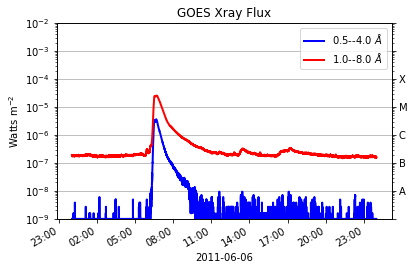

In [5]:
goesXRS_TS = TimeSeries(filesXRS, source= 'XRS')
goesXRS_TS.peek()

Se observan dos curvas, una roja y otra azul, se tomará la curva roja, que corresponde a los datos 'xrsb'. Sobre esa curva se deben de buscar los picos y extraer las fechas. La función definida abajo, findpeaks(series, DELTA), toma una serie de datos de cualquier curva y encuentra los puntos mínimos y máximos. Para ello usa como criterio la variable DELTA, que es la mínima distancia en el eje 'y' que define a un pico de otro. 

In [6]:
def findpeaks(series, DELTA):
    # Valores iniciales
    mn, mx = np.Inf, -np.Inf
    minpeaks = []
    maxpeaks = []
    lookformax = True
    start = True
    # Se itera sobre cada uno de los elementos en la serie
    for time_pos, value in series.iteritems():
        if value > mx:
            mx = value
            mxpos = time_pos
        if value < mn:
            mn = value
            mnpos = time_pos
        if lookformax:
            if value < mx-DELTA:
                # un maximo local
                maxpeaks.append((mxpos, mx))
                mn = value
                mnpos = time_pos
                lookformax = False
            elif start:
                # un minimo local al principio
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                start = False
        else:
            if value > mn+DELTA:
                # minimo local
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                lookformax = True
    
    # Se revisa al principio y al final
    if value > mn+DELTA:
        maxpeaks.append((mxpos, mx))
    elif value < mx-DELTA:
        minpeaks.append((mnpos, mn))
    return minpeaks, maxpeaks

Se procede a tomar la serie de datos 'xrsb' del TimeSeries y se le envía a la función findpeaks. Seguidamente se imprime los picos máximos y se plotea la curva identificando los picos máximos con un punto rojo.

Los picos máximos son:
                           0             1
0 2011-06-07 06:30:57.441999  2.456800e-05
1 2011-06-07 06:32:52.128999  2.448400e-05
2 2011-06-07 06:33:51.518999  2.450500e-05
3 2011-06-07 06:39:11.001999  2.546000e-05
4 2011-06-07 06:41:24.118999  2.555400e-05
5 2011-06-07 13:28:05.584999  3.224900e-07
6 2011-06-07 17:12:10.468999  3.434800e-07


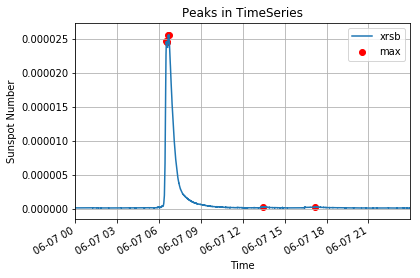

In [7]:
#Se extrae la serie xrsb
xrs_Series = goesXRS_TS.data['xrsb']

#Se extraen los picos mínimos y máximos de la serie
min_picos, max_picos = findpeaks(xrs_Series, DELTA=0.0000001)

#Se imprimen los picos máximos encontrados 
print ('Los picos máximos son:')
print (pd.DataFrame(max_picos))


#Se plotea la curva con los picos máximos 
plt.figure()
plt.ylabel('Sunspot Number')
plt.xlabel('Time')
plt.title('Peaks in TimeSeries')
xrs_Series.plot()
plt.scatter(*zip(*max_picos), color='red', label='max') # Punto de color rojo en máximos
plt.legend()
plt.grid(True)
plt.show()

 Se procede a descartar todos los picos que sean menores a $10^{-6}$ y se vuelve a plotear la curva.

In [8]:
#Variable donde se guardarán los picos mayores a 1x10^(-6)
maxPicosArriba10e_m06 = []

#Se recorre y se revisa todos los máximos
for i in range(0, len(max_picos)-1):
    if max_picos[i][1] > 1.0e-06:
        maxPicosArriba10e_m06.append(max_picos[i])
    
#Se imprimen picos por encima del limite establecido
print ('Los picos máximos por encima de 1x10^(-6) son: \n')
print (pd.DataFrame(maxPicosArriba10e_m06))


Los picos máximos por encima de 1x10^(-6) son: 

                           0         1
0 2011-06-07 06:30:57.441999  0.000025
1 2011-06-07 06:32:52.128999  0.000024
2 2011-06-07 06:33:51.518999  0.000025
3 2011-06-07 06:39:11.001999  0.000025
4 2011-06-07 06:41:24.118999  0.000026


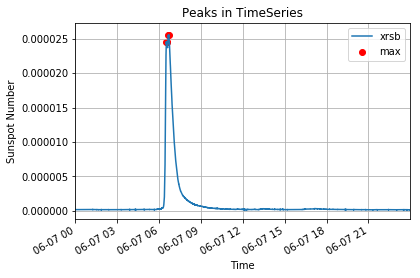

In [9]:
#Se plotea la curva con los picos máximos 
plt.figure()
plt.ylabel('Sunspot Number')
plt.xlabel('Time')
plt.title('Peaks in TimeSeries')
xrs_Series.plot()
plt.scatter(*zip(*maxPicosArriba10e_m06), color='red', label='max')
plt.legend()
plt.grid(True)
plt.show()

Una vez identificados los picos máximos en la curva del XRS, se procede a guardar un archivo en formato .csv con dicha información. 

In [10]:
#Se define DataFrame de pandas para guardar
#información en archivo .csv
dataFrameMaxPicos = pd.DataFrame(maxPicosArriba10e_m06)
dataFrameMaxPicos.to_csv('DatosJupyterSun/maxPicos.csv', sep='\t', index=False)

A continuación se define la función returnDataRange(centralDate, delta_min), la cual toma las fechas de los picos máximos detectados en las curvas, y crea un rango de tiempo con un delta_min = 30 min antes y después.

In [11]:
#Define un TimeRange de una hora, a partir de la hora central extraída
#en la curva XRS. Con el TimeRange se busca en la base de datos JSOC
#los archivos FITS
def returnDataRange(centralDate, delta_min):
    date_rangeUp = TimeRange(centralDate, delta_min * u.min).previous()
    date_rangeFinal = TimeRange(date_rangeUp.start, date_rangeUp.next().end)
    return date_rangeFinal

#Se define el TimeRange, a partir de un pico máximo
maxPicoTR = returnDataRange(maxPicosArriba10e_m06[4][0], 30)
print (maxPicoTR)

    Start: 2011-06-07 06:11:24
    End:   2011-06-07 07:11:24
    Center:2011-06-07 06:41:24
    Duration:0.0416666666667 days or
           1.0 hours or
           60.0 minutes or
           3600.0 seconds



Con el rango de tiempo definido anteriormente, se procede con la busqueda y descarga de los archivos FITS del AIA/SDO.

In [12]:
#Se busca en el rango de tiempo definido anteriormente, los datos corresponden
#a la serie aia.lev1 con una cadencia de 12 segundos, una longitud de onda de
#193 Ångström
resultsAIA = Fido.search(a.jsoc.Time(maxPicoTR.start, maxPicoTR.end), a.jsoc.Series('aia.lev1_euv_12s'), a.jsoc.Wavelength(193*u.AA), a.vso.Sample(2*u.minute),  a.jsoc.Notify('yasser.wagon@ucr.ac.cr'))
resultsAIA

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
unicode20,unicode7,unicode5,int64,int64
2011-06-07T06:11:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:13:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:15:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:17:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:19:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:21:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:23:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:25:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:27:26Z,SDO/AIA,AIA_2,193,2111


In [ ]:
#Se descargan los archivos FITS
downloaded_files = Fido.fetch(resultsAIA, path='DatosJupyterSun/JSOC_AIA_FITS/{file}.fits')

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])


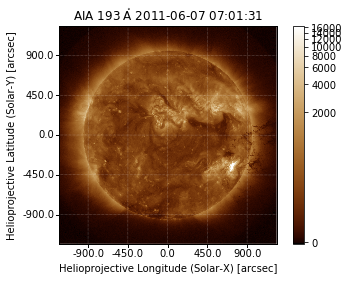

In [21]:
#Se abre archivo FITS y se convierte a un objeto map de sunpy
fits_image_filename = 'DatosJupyterSun/JSOC_AIA_FITS/aia.lev1_euv_12s.2011-06-07T070133Z.193.image_lev1.fits'

aiamap = sunpy.map.Map(fits_image_filename)
aiamap1 = sunpy.map.Map(fits_image_filename)

plt.figure()
aiamap.plot()
plt.colorbar()


Se delimita la zona de interes con un cuadro de lado igual a (2)(0.75*R_SUN) y centrado en el disco solar. Para ello se ingresa al metadata del map y se extraen las coordenadas en pixeles del sol, además del radio, y se guardan en variables.

In [14]:
crpix1 = int(aiamap.meta['CRPIX1'])
crpix2 = int(aiamap.meta['CRPIX2'])
rSun = int(aiamap.meta['R_SUN'])
sunCenter = np.array([crpix1, crpix2])

print('El centro del disco solar está en el punto: ', sunCenter)
print ('El radio del sol en pixeles es: ', rSun)


El centro del disco solar está en el punto:  [2044 2048]
El radio del sol en pixeles es:  1574


Se define la función, drawROI(sunImageData, sunCenter, pixRadius, proportion), que se encargará de dibujar un cuadro que delimitará la ROI.

In [15]:
def drawROI(sunImageData, sunCenter, pixRadius, proportion):
    propRadius = int(proportion * pixRadius)
    cv.rectangle(sunImageData, (sunCenter[0] - propRadius, sunCenter[1] - propRadius), (sunCenter[0] + propRadius, sunCenter[1] + propRadius), 0, 30)
#    cv.circle(sunImageData, (sunCenter[0], sunCenter[1]), propRadius, 0, 30, cv.LINE_AA)
    return sunImageData

Se dibuja el ROI sobre el map del archivo FITS abierto y se gráfica.

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])


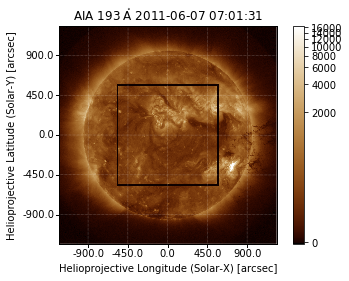

In [16]:
drawROI(aiamap.data, sunCenter, rSun, 0.6)
plt.figure()
aiamap.plot()
plt.colorbar()


Se procederá a ubicar los picos de alta intensidad en el map. Para ello se hace uso de la librería skimage con su función peak_local_max(). Se definen los pixeles de alta intesidad, los que tengan un valor de al menos un 80% del pixel más intenso.

In [17]:
coorPicos = peak_local_max(aiamap.data, min_distance=200, threshold_rel=0.2)
print('Los puntos de alta intensidad en el map son: \n')
print (pd.DataFrame(coorPicos))

Los puntos de alta intensidad en el map son: 

      0     1
0  2526  3361
1  2525  3361
2  2517  2949
3  2365   493
4  2330  1846
5  2295  2360
6  1482  3256


Se marca con una equis azul los picos de alta intensidad en el map. Sin embargo, solo se requieren los picos que se encuentren en la Región de Ínteres(ROI).

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


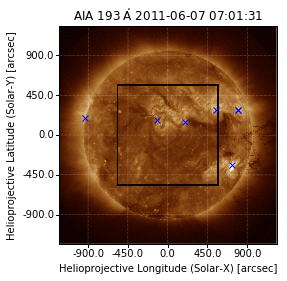

In [19]:
hpc_max = aiamap.pixel_to_world(coorPicos[:, 1]*u.pixel, coorPicos[:, 0]*u.pixel)
fig = plt.figure()
ax = plt.subplot(projection=aiamap)
aiamap.plot()
ax.plot_coord(hpc_max, 'bx')
plt.show()

La función picosROI(), descarta todos aquellos picos que se encuentren fuera del ROI. Retorna un arreglo con las coordenadas de los picos que esten dentro del ROI.

In [20]:
def picosROI(coordenadasPicos, sunCenter, pixRadius, prop):
    propRadius = int(prop * pixRadius)
    picosEnROI = []
    for s in range(0, len(coordenadasPicos)-1):
        if (coordenadasPicos[s][0] > sunCenter[0] - propRadius and coordenadasPicos[s][0] < sunCenter[0] + propRadius):
            if(coordenadasPicos[s][1] > sunCenter[1] - propRadius and coordenadasPicos[s][1] < sunCenter[1] + propRadius):
                picosEnROI.append(coordenadasPicos[s])
                
    return np.array(picosEnROI)

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


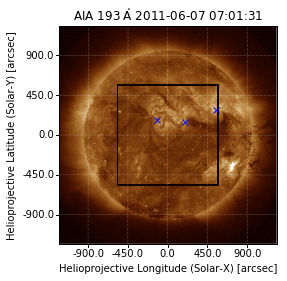

In [24]:
#Se ubican los picos de alta intensidad dentro del ROI 
picosen_roi = picosROI(coorPicos, sunCenter, rSun, 0.6)
#Se dibuja ROI en map
drawROI(aiamap.data, sunCenter, rSun, 0.6)
#Se mapean las coordenadas en el map
hpc_max1 = aiamap1.pixel_to_world(picosen_roi[:, 1]*u.pixel, picosen_roi[:, 0]*u.pixel)

#Se grafica la imagen con los picos de alta intensidad dentro del ROI, marcados con una equis azul
fig = plt.figure()
ax = plt.subplot(projection=aiamap)
aiamap.plot()
ax.plot_coord(hpc_max1, 'bx')
plt.show()


La función guardar3DPlotROI() se encarga de realizar un gráfico en 3D del ROI, para cada uno de los archivos FITS de la carpeta que se le índique. La función tiene como entrada el path del directorio donde estarán contenidos los archivos FITS, la ubicación de los picos de alta intensidad dentro del ROI, el centro del sol, el radio y la proporción del ROI con respecto al disco solar.

In [25]:
def guardar3DPlotROI(FITS_dirPath, picosEnROI, sunCenter, pixRadius, prop):
    #Se obtienen las direcciones de los archivos FITS a gráficar
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    print (len(fitsPaths))
    
    # Se itera sobre cada archivo FITS del directorio
    for i in range(0, len(fitsPaths)):
        # Se crea objeto Map y se obtiene el centro(sunC) y radio(radiusSun) 
        # del disco solar de los metadatos 
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        propRadius = int(prop * pixRadius)
        
        x = np.arange(aiamapFITS_i.data.shape[0])
        y = np.arange(aiamapFITS_i.data.shape[1])
        X, Y = np.meshgrid(x[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius)], y[int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
        
        time_obs = str(aiamapFITS_i.meta['date-obs'])
        if('.84' in time_obs):          
            fig = plt.figure(figsize=(12,8))
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, aiamapFITS_i.data[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius), int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
            ax.set_zlim(0, 8000)
            ax.view_init(elev=39, azim=64)
            peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
            ax.scatter(picosEnROI[:, 1], picosEnROI[:, 0], peaks_pos, color='r')
            ax.set_xlabel('X Coordinates')
            ax.set_ylabel('Y Coordinates')
            ax.set_zlabel('Intensity')
        
            plt.savefig('DatosJupyterSun/3D/'+str(aiamapFITS_i.meta['date-obs'])+'.png', bbox_inches='tight')
        
            plt.close(fig)

Se procede a realizar el gráfico 3D de cada uno de los archivos FITS previamente descargados.

In [26]:
#Se define en una variable el path del directorio
fitsDir = 'DatosJupyterSun/JSOC_AIA_FITS'
#Se llama a la función guardar3DPlotROI, para generar las gráficas
guardar3DPlotROI(fitsDir, picosen_roi, sunCenter, rSun, 0.6)


32


Con los picos de alta intensidad identificados en los maps, se procede a realizar el registro de las intensidades a través del tiempo. Se define la función obtenerIntensidadesDePicosROI() que recorrerá los archivos FITS y extraerá las intensidades de los picos dentro del ROI. Se retorna una matriz con la información.

In [27]:
def obtenerIntensidadesDePicosROI (FITS_dirPath, picosEnROI):
    #Se obtiene el path de los archivos FITS contenidos en el directorio
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    matrix = [['Time']]
    
    #Se ingresa la coordenada de los picos de alta intensidad en las columnas de la
    #fila cero.
    for k in range(0, len(picosEnROI)):
        matrix[0].append(picosEnROI[k])
    
    #Se itera sobre los archivos FITS y se extrae la intensidad
    for i in range(0, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        row_i = []
        time_obs = str(aiamapFITS_i.meta['date-obs'])
        if('.84' in time_obs):
            row_i.append(parse_time(time_obs))            
            peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
            for s in range(0, len(peaks_pos)):
                row_i.append(peaks_pos[s])
            
            matrix.append(row_i)
        
        
    return np.array(matrix)


Se obtienen las intensidades de los picos de los maps y se imprime.

In [29]:
matriz = obtenerIntensidadesDePicosROI(fitsDir, picosen_roi)
pd.DataFrame(matriz).to_csv('DatosJupyterSun/maxPicosEvolucion.csv', sep='\t', index=False)
print (pd.DataFrame(matriz, index=None, columns=None))

                             0             1             2             3
0                         Time  [2517, 2949]  [2330, 1846]  [2295, 2360]
1   2011-06-07 06:59:31.840000          9282          5856          4566
2   2011-06-07 07:03:31.840000          8403          5679          4584
3   2011-06-07 07:05:31.840000          7591          5600          4655
4   2011-06-07 06:16:31.840000          5394          1965          3149
5   2011-06-07 07:07:31.840000          7430          5066          4531
6   2011-06-07 07:09:31.840000          7114          4508          4566
7   2011-06-07 06:25:31.840000          5355          1839          3076
8   2011-06-07 06:27:31.840000          5355          2091          3163
9   2011-06-07 06:29:31.840000          5239          2846          3251
10  2011-06-07 06:33:31.840000          5750          3816          3633
11  2011-06-07 06:35:31.840000          6284          4197          3774
12  2011-06-07 06:37:31.840000          6413       

Se crea un TimeSeries con la matriz anterior y se gráfica para ver la evolución de los picos en el tiempo.

/usr/local/lib/python2.7/dist-packages/sunpy/timeseries/timeseriesbase.py:502: Warning: Unknown units for "0"
  warnings.warn("Unknown units for \""+str(column)+"\"", Warning)
/usr/local/lib/python2.7/dist-packages/sunpy/timeseries/timeseriesbase.py:502: Warning: Unknown units for "1"
  warnings.warn("Unknown units for \""+str(column)+"\"", Warning)
/usr/local/lib/python2.7/dist-packages/sunpy/timeseries/timeseriesbase.py:502: Warning: Unknown units for "2"
  warnings.warn("Unknown units for \""+str(column)+"\"", Warning)
/usr/local/lib/python2.7/dist-packages/sunpy/timeseries/timeseriesbase.py:502: Warning: Unknown units for "3"
  warnings.warn("Unknown units for \""+str(column)+"\"", Warning)
/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


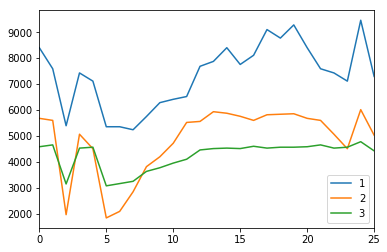

In [30]:
tsROI = TimeSeries(pd.DataFrame(matriz[1:][1:], index=None, columns=None))
tsROI.peek()

La fucnión arrayMaps() se encarga de mostrar la imágenes en un array para observalas de manera secuencial

In [33]:
def arrayMaps(FITS_dirPath):
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    img = []
    
    fig = plt.figure(figsize=(40,40))
    for i in range(0, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        time_obs = str(aiamapFITS_i.meta['date-obs'])
        if('.84' in time_obs):
            fig.add_subplot(4, 8, i+1)
            aiamapFITS_i.plot()

        
    plt.show
    

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:1734: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:1734: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:1734: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:1734: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:1734: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:1734: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:753: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  [1/lam * np.sin(p), np.cos(p)]])
/usr/local/lib/python2.7/dist-packages/sunpy/map/mapbase.py:1734: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

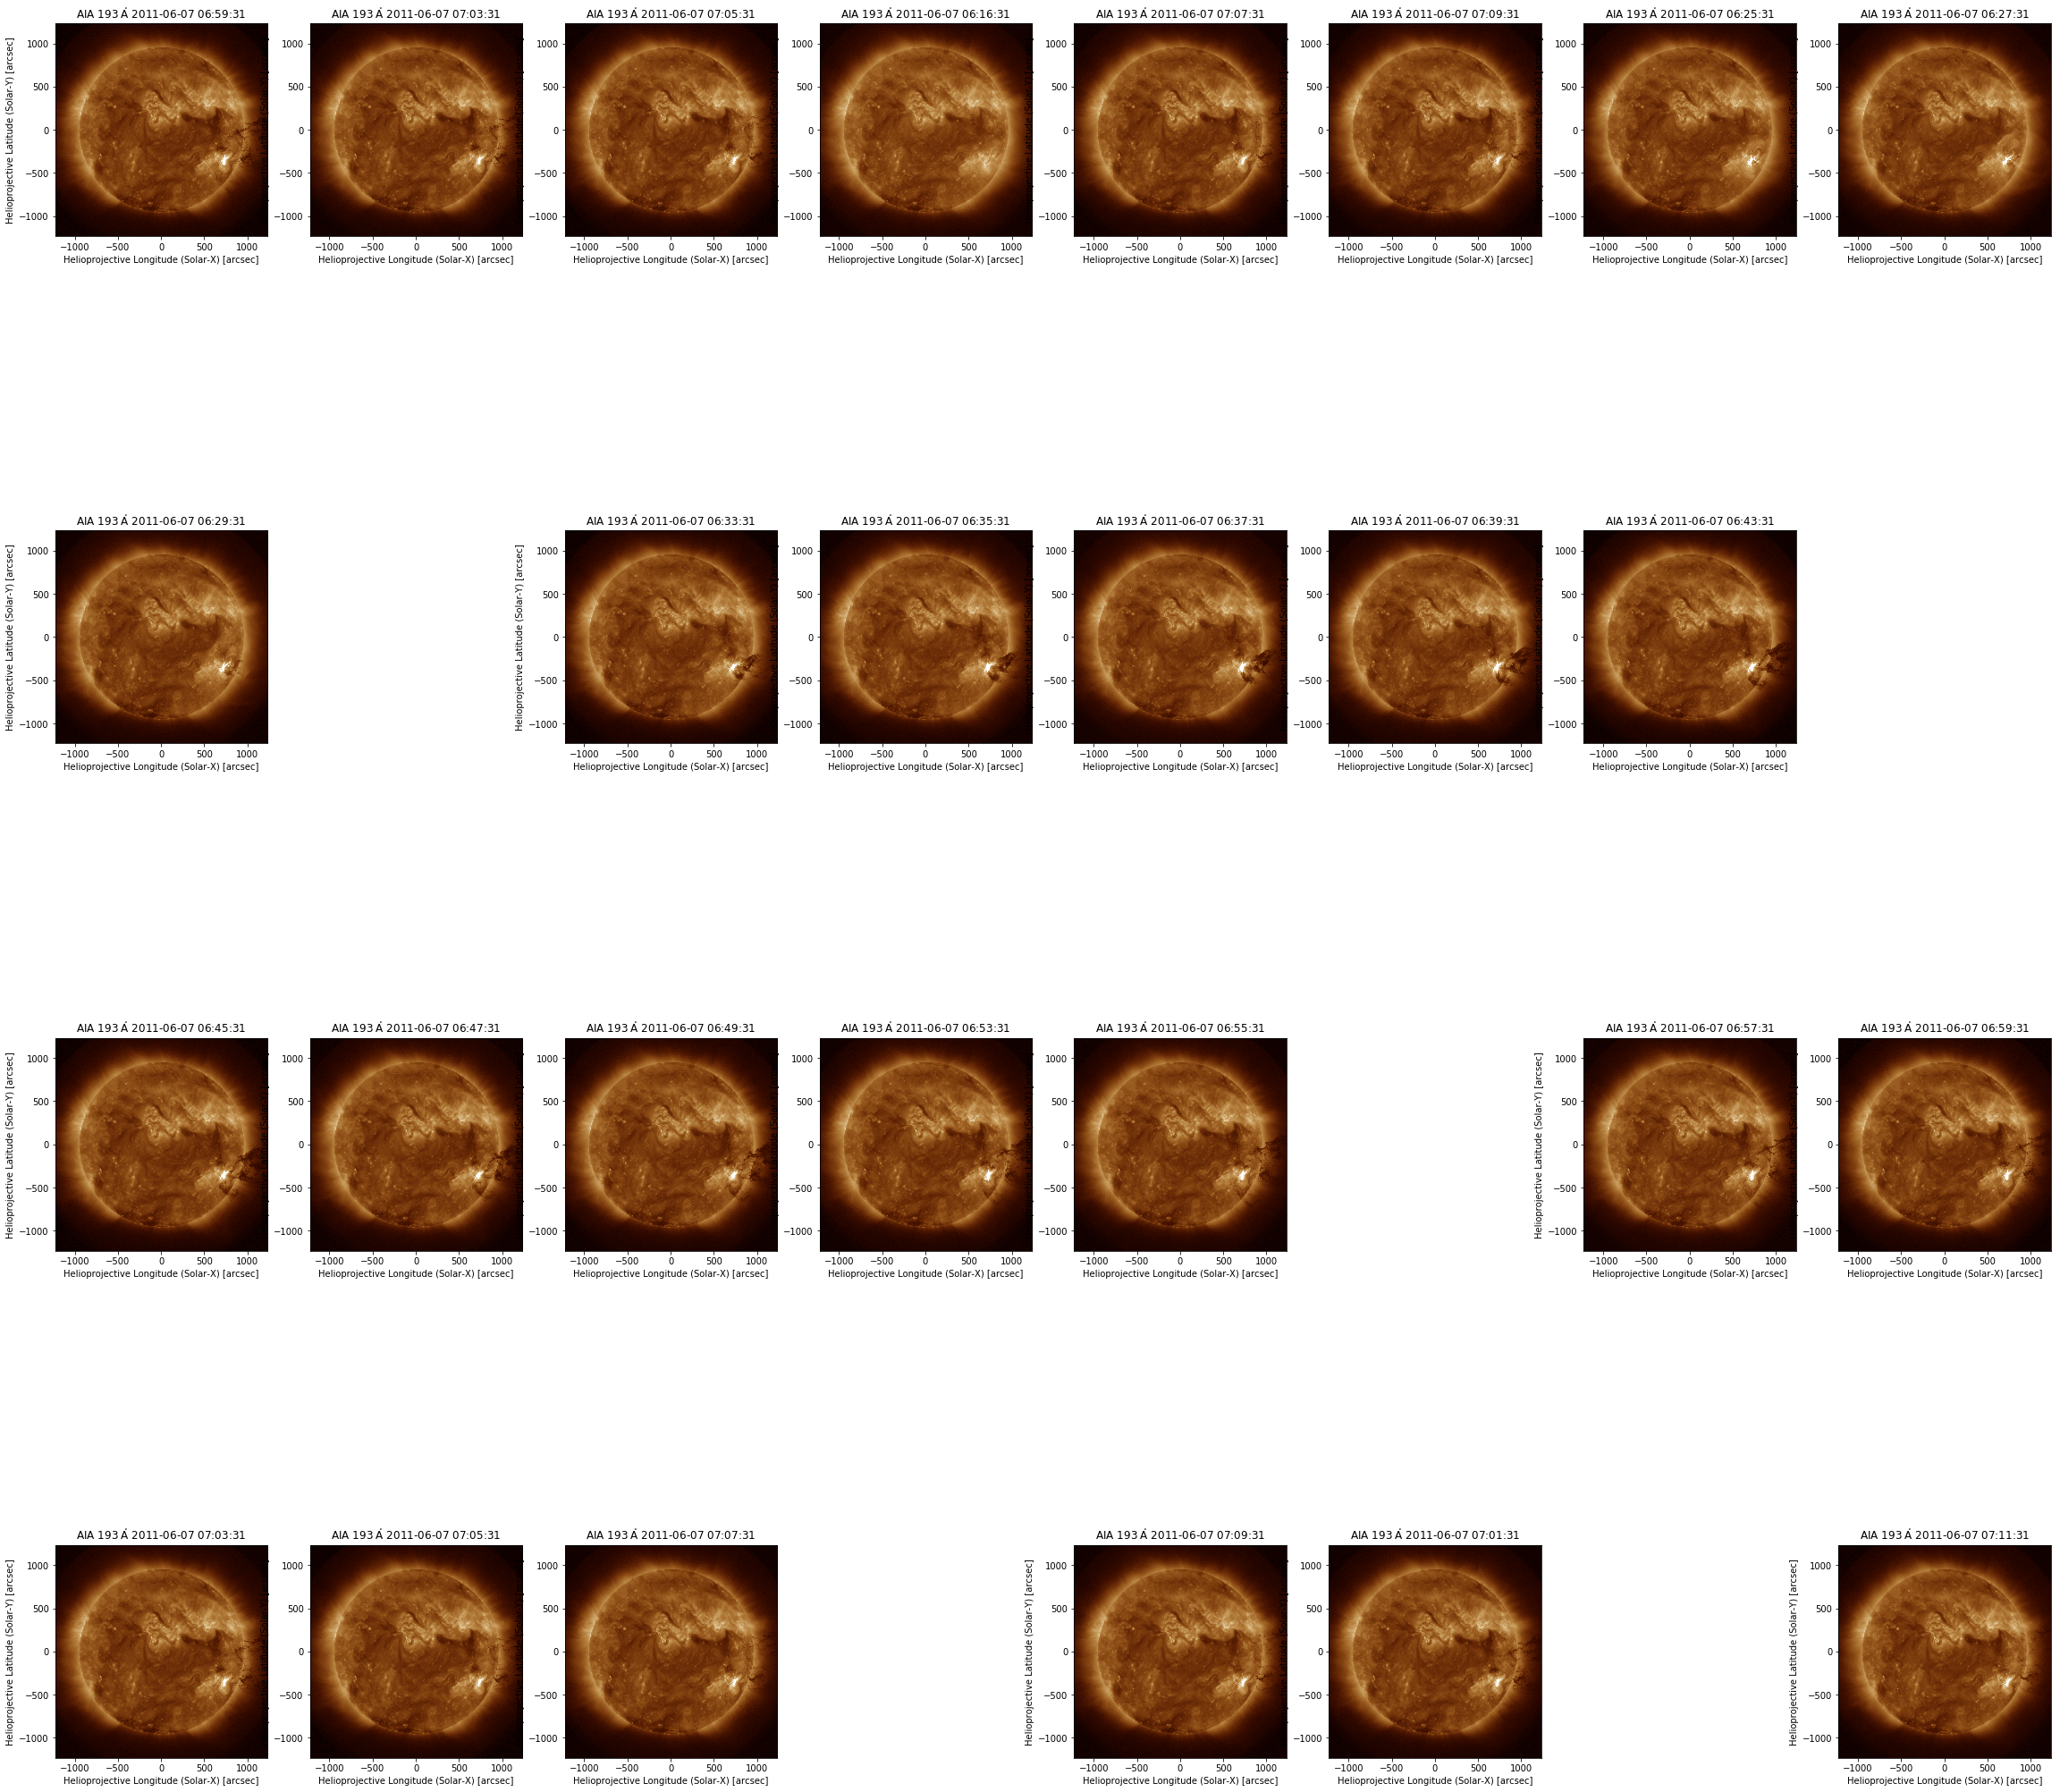

In [34]:
#Se envían los archivos FITS para que se grafiquen en un arreglo
arrayMaps(fitsDir)

La función convert_frames_to_video() se encarga de tomar los frames de las imágenes en 3D del ROI y genera un vídeo para observar mejor la dinámica de los pixeles en la región de interes. 

In [35]:
def convert_frames_to_video(pathIn,pathOut,fps):    
    frame_array = []
    files = sorted(glob(str(pathIn)+'/*.png'))
 
    #for sorting the file names properly
    
    for i in range(len(files)):
        filename=files[i]
        #reading each files
        img = cv.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv.VideoWriter(pathOut,cv.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [36]:
#Se define el path del directorio donde están contenidas las imágenes 3D
pathIn = 'DatosJupyterSun/3D'
#Se define el path donde se guardará el video
pathOut = 'DatosJupyterSun/video.avi'
#Es posible ajustar los fotogramas por segundo(fps) del vídeo
fps = 3.0
#Se genera el vídeo con las variables definidas anteriormente
convert_frames_to_video(pathIn, pathOut, fps)